# MADE提案によるMCMCコードテスト

## import

In [181]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
import random

import mcmc_function as mcmc
import ising_model as ising
from ising_model import Ising_model
import QAOA_function as qaoa
from QAOA_function import QAOA_ansatz
import made

seed = 1454
rng = np.random.default_rng(seed)
random.seed(seed)
generator = torch.Generator().manual_seed(seed)

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['mathtext.fontset'] = 'cm'

## 0. インスタンス準備

In [182]:
n_spin = 8
instance = Ising_model(n_spin, rng, type='SK')
beta = 5.0

## 1. MADE提案生成

### QAOAサンプル生成

In [183]:
# setting
n_layers = 5
qaoa_init_para = [0.2705, -0.5899, 0.4803, -0.4492, 0.5074, -0.3559, 0.5646, -0.2643, 0.6397, -0.1291] #文献におけるSKmodelに対するQAOA(p=5)の固定角
qaoa_method = "BFGS"
qaoa_options = {"disp": False, "maxiter": 200, "gtol": 1e-6}

# optimize QAOA ansatz
prob_hamiltonian = instance.get_hamiltonian()
mixer_hamiltonian = qaoa.generate_X_mixer(n_spin)
qaoa_ansatz = QAOA_ansatz(prob_hamiltonian, mixer_hamiltonian, n_layers)

def qaoa_cost(para):
	return qaoa.cost_QAOA(prob_hamiltonian, qaoa_ansatz, para)

qaoa_opt = scipy.optimize.minimize(qaoa_cost, qaoa_init_para, method=qaoa_method, options=qaoa_options)

### MADEの訓練

In [184]:
# setting
n_train = 100
n_test = int(n_train * 0.25)

hidden_size = int(2 * n_spin)
hidden_layers = 2
batchsize = 8
lr = 0.005
n_epochs = 30

# generate train/test datasets
qaoa_opt_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, qaoa_opt.x, n_train+n_test) # optimize parameter
qaoa_opt_data_nd = np.array([qaoa.number_to_binary(qaoa_opt_data_idx[i], n_spin) for i in range(len(qaoa_opt_data_idx))], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！
qaoa_opt_data = torch.from_numpy(qaoa_opt_data_nd).to(dtype=torch.float32)
qaoa_opt_traindata, qaoa_opt_testdata = torch.utils.data.random_split(dataset=qaoa_opt_data, lengths=[n_train, n_test], generator=generator)
qaoa_opt_testset = torch.utils.data.DataLoader(qaoa_opt_testdata, batch_size=batchsize, shuffle=False)
qaoa_opt_trainset = torch.utils.data.DataLoader(qaoa_opt_traindata, batch_size=batchsize, shuffle=True)

# learn MADE by QAOA samples
hidden_list = [hidden_size for i in range(hidden_layers)]
model_qaoa_opt = made.MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
opt_qaoa_opt = torch.optim.Adam(model_qaoa_opt.parameters(), lr=lr, weight_decay=1e-4)
scheduler_qaoa_opt = torch.optim.lr_scheduler.StepLR(opt_qaoa_opt, step_size=45, gamma=0.1)
train_loss, test_loss = made.run_train(model_qaoa_opt, qaoa_opt_trainset, qaoa_opt_testset, n_epochs, opt_qaoa_opt, scheduler_qaoa_opt, seed)

### 訓練過程の確認

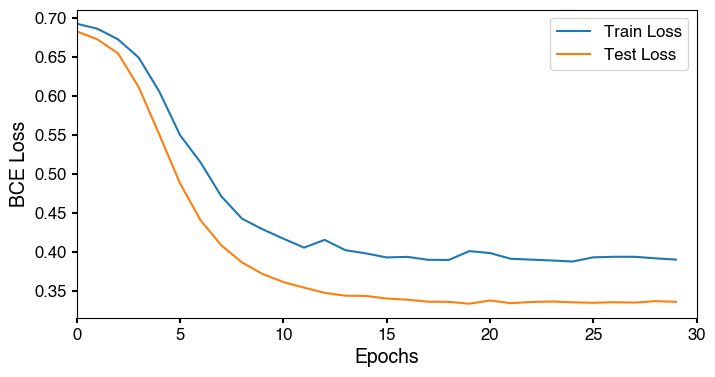

In [185]:
fig1, ax1 = plt.subplots(figsize=(8,4), dpi=100)
ax1.plot(np.arange(n_epochs), train_loss, label='Train Loss')
ax1.plot(np.arange(n_epochs), test_loss, label='Test Loss')
ax1.set_xlabel("Epochs", fontsize=14)
ax1.set_ylabel("BCE Loss", fontsize=14)
ax1.tick_params(width=1.5, labelsize=12)
ax1.set_xlim(0, n_epochs)
ax1.legend(fontsize=12)

## 2-1. spectral gap計算

In [186]:
# calculate probs of MADE outputs
all_inputs = np.array([made.number_to_binary(i, n_spin) for i in range(2**n_spin)])
qaoa_opt_pred_dist = made.compute_log_prob(model_qaoa_opt, all_inputs)
qaoa_opt_pred_dist = np.exp(qaoa_opt_pred_dist)

# get proposal matrix
qaoa_opt_made_Q = np.zeros((2**n_spin, 2**n_spin))
uni_Q = np.ones((2**n_spin, 2**n_spin)) / (2**n_spin)

for i in range(2**n_spin):
	for j in range(2**n_spin):
		qaoa_opt_made_Q[j,i] = qaoa_opt_pred_dist[j]

 # calculate spectral gap
energy = np.array([ising.spin_energy(ising.number_to_spin(i, n_spin), instance) for i in range(2**n_spin)])

# MADE(QAOA)
qaoa_opt_made_P = np.zeros((2**n_spin, 2**n_spin))
uni_P = np.zeros((2**n_spin, 2**n_spin))

qaoa_opt_made_A = mcmc.calc_boltzmann_mh_acceptance(energy, qaoa_opt_made_Q, beta)
metropolis_A = mcmc.calc_boltzmann_metropolis_acceptance(energy, beta)

qaoa_opt_made_P = qaoa_opt_made_Q * qaoa_opt_made_A
uni_P = uni_Q * metropolis_A

np.fill_diagonal(qaoa_opt_made_P, 0)
np.fill_diagonal(uni_P, 0)

for i in range(2**n_spin):
	qaoa_opt_made_P[i,i] = 1 - np.sum(qaoa_opt_made_P[:,i])
	uni_P[i,i] = 1 - np.sum(uni_P[:,i])

qaoa_opt_made_gap = mcmc.spectral_gap(qaoa_opt_made_P)
uni_gap = mcmc.spectral_gap(uni_P)

In [187]:
print('MADE+QAOA(opt): {0}'.format(qaoa_opt_made_gap))
print('Uniform: {0}'.format(uni_gap))

MADE+QAOA(opt): 0.2568376280311151
Uniform: 0.009859380596427991


## 2-2. MCMCシミュレーション

### MCMC更新の関数

In [188]:
def uniform_update_mcmc(init_spin, instance, beta, n_iter, rng=None):
	if rng == None:
		rng = np.random.default_rng()
    
    # preparation
	n_spin = init_spin.shape[0]
	state_history = np.zeros((n_iter+1, n_spin))
	state_history[0] = init_spin
	acceptance_history = np.zeros(n_iter)

	accept_state = init_spin

	for i in range(n_iter):
		# make a porposal
		proposal_state = mcmc.number_to_spin(rng.integers(0, 2**n_spin), n_spin)

		# accept or reject the proposal
		next_state, acceptance, flag = mcmc.boltzmann_metropolis(accept_state, proposal_state, instance, beta, rng)

		# update the accept_state
		state_history[i+1] = next_state
		acceptance_history[i] = acceptance
		if flag:
			accept_state = next_state
	
	return state_history, acceptance_history

def neural_update_mcmc(init_spin, instance, model, beta, n_iter, rng=None):
	if rng == None:
		rng = np.random.default_rng()
    
    # preparation
	n_spin = init_spin.shape[0]
	state_history = np.zeros((n_iter+1, n_spin))
	state_history[0] = init_spin
	acceptance_history = np.zeros(n_iter)

	current_state = init_spin
	current_log_prob = made.compute_log_prob(model, made.spin_to_binary(init_spin))

	for i in range(n_iter):
		# make a porposal
		proposal_state_nd = made.predict(model, 1)[0]
		proposal_state = made.binary_to_spin(proposal_state_nd)
		proposal_log_prob = made.compute_log_prob(model, proposal_state_nd)

		# accept or reject the proposal
		next_state, acceptance, flag = mcmc.boltzmann_metropolis_hastings(current_state, proposal_state, proposal_log_prob, current_log_prob, instance, beta, rng)

		# update the accept_state
		state_history[i+1] = next_state
		acceptance_history[i] = acceptance
		if flag:
			current_state = next_state
			current_log_prob = made.compute_log_prob(model, made.spin_to_binary(next_state))
	
	return state_history, acceptance_history


### 本シミュレーション

In [189]:
# setting
n_iter = 1000

# initialize the state
init_spin = mcmc.number_to_spin(rng.integers(0, 2**n_spin), n_spin)
print(init_spin)

# main simulation
state_hist_made, acceptance_hist_made = neural_update_mcmc(init_spin, instance, model_qaoa_opt, beta, n_iter, rng)
state_hist_uni, acceptance_hist_uni = uniform_update_mcmc(init_spin, instance, beta, n_iter, rng)

[-1  1  1  1 -1  1 -1  1]


### 結果

#### 状態遷移の様子

[-1.  1.  1.  1. -1.  1. -1.  1.]
[-1.  1.  1.  1. -1.  1. -1.  1.]


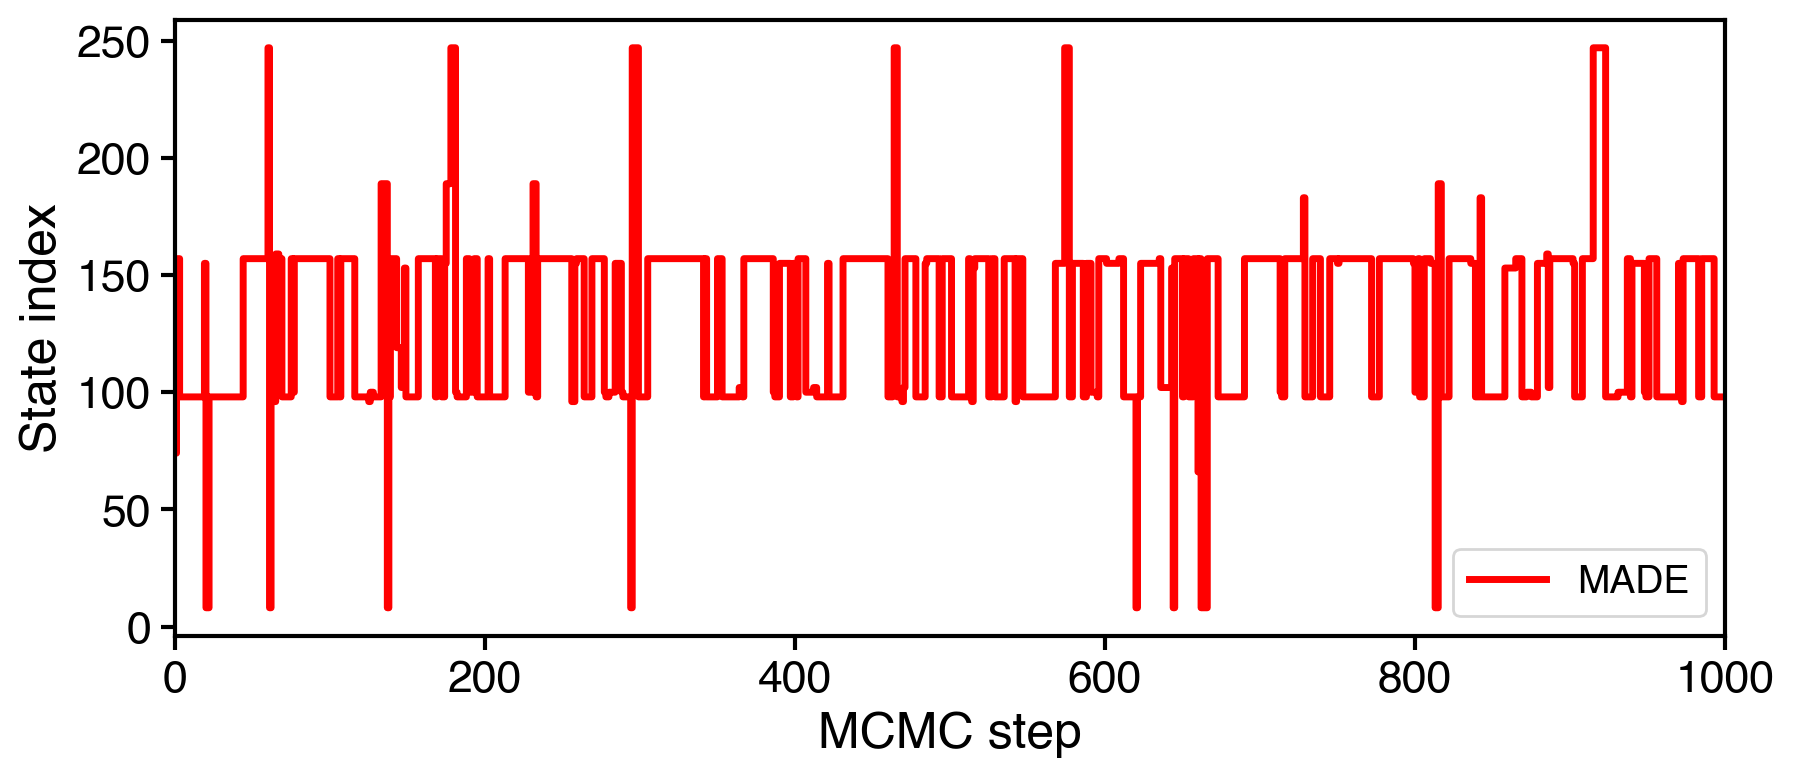

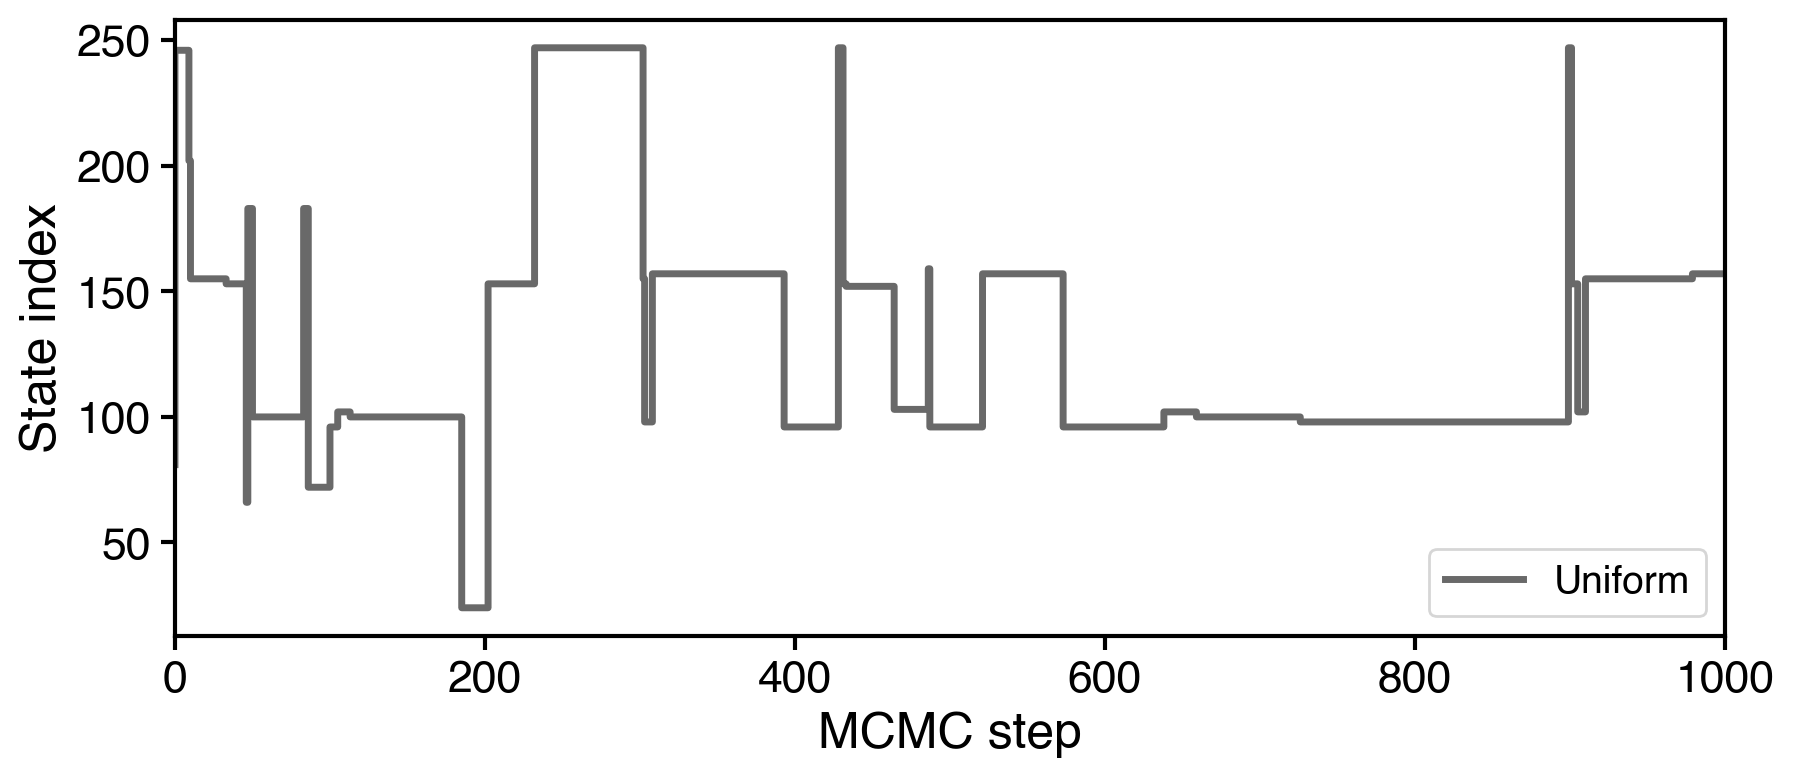

In [193]:
state_hist_made_idx = np.array([ising.spin_to_number(state_hist_made[i]) for i in range(state_hist_made.shape[0])])
state_hist_uni_idx = np.array([ising.spin_to_number(state_hist_uni[i]) for i in range(state_hist_uni.shape[0])])

print(state_hist_made[0])
print(state_hist_uni[0])

# plot
capsize = 4
markersize = 7.5
elinewidth = 2.5
capthick = 2.5
linewidth = 2.5
spines = 1.5

fig2_1, ax2_1 = plt.subplots(figsize=(10,4), dpi=200)

ax2_1.spines["top"].set_linewidth(spines)
ax2_1.spines["left"].set_linewidth(spines)
ax2_1.spines["bottom"].set_linewidth(spines)
ax2_1.spines["right"].set_linewidth(spines)

ax2_1.step(np.arange(n_iter+1), state_hist_made_idx, color='red', linewidth=linewidth, label='MADE')

ax2_1.set_xlim(0, n_iter)
#ax2_1.set_ylim(-0.3,0.3)
ax2_1.set_xlabel('MCMC step', fontsize=18)
ax2_1.set_ylabel('State index', fontsize=18)
ax2_1.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax2_1.tick_params(axis="x", which='major', width=1.5)
ax2_1.legend(fontsize=14, loc='lower right', frameon=True)

fig2_2, ax2_2 = plt.subplots(figsize=(10,4), dpi=200)

ax2_2.spines["top"].set_linewidth(spines)
ax2_2.spines["left"].set_linewidth(spines)
ax2_2.spines["bottom"].set_linewidth(spines)
ax2_2.spines["right"].set_linewidth(spines)

ax2_2.step(np.arange(n_iter+1), state_hist_uni_idx, color='dimgrey', linewidth=linewidth, label='Uniform')

ax2_2.set_xlim(0, n_iter)
#ax2_2.set_ylim(-0.3,0.3)
ax2_2.set_xlabel('MCMC step', fontsize=18)
ax2_2.set_ylabel('State index', fontsize=18)
ax2_2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax2_2.tick_params(axis="x", which='major', width=1.5)
ax2_2.legend(fontsize=14, loc='lower right', frameon=True)

### 平均磁化の推定

(1001,)


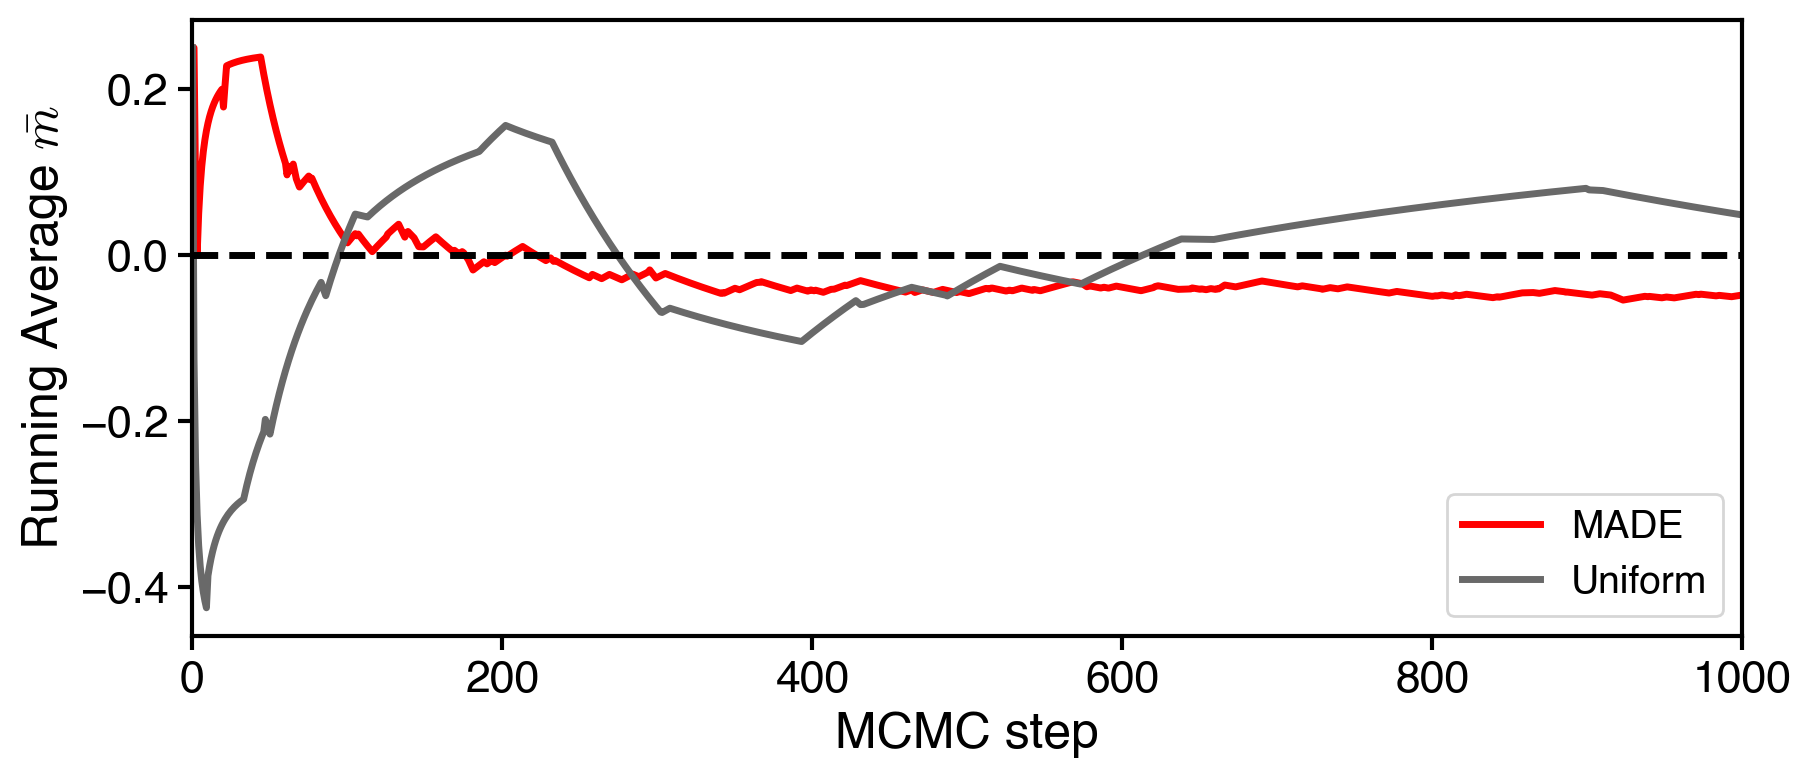

In [194]:
# caluculate the average magnetization
mag_made = np.average(state_hist_made, axis=1)
mag_uni = np.average(state_hist_uni, axis=1)
print(mag_made.shape)

normalize = np.arange(1, state_hist_made.shape[0]+1)
ave_mag_made = np.cumsum(mag_made) / normalize
ave_mag_uni = np.cumsum(mag_uni) / normalize

# true value of average magnetization for the instance
boltzmann_dist = ising.spin_boltzmann_distribution(instance, beta)
true_val = ising.boltzmann_average_magnetization(n_spin, boltzmann_dist)

# plot
n_range = n_iter
fig3, ax3 = plt.subplots(figsize=(10,4), dpi=200)

ax3.spines["top"].set_linewidth(spines)
ax3.spines["left"].set_linewidth(spines)
ax3.spines["bottom"].set_linewidth(spines)
ax3.spines["right"].set_linewidth(spines)

ax3.plot(np.arange(n_iter+1), ave_mag_made, color='red', linewidth=linewidth, label='MADE')
ax3.plot(np.arange(n_iter+1), ave_mag_uni, color='dimgrey', linewidth=linewidth, label='Uniform')
ax3.axhline(true_val, color='black', linestyle='--', linewidth=linewidth)

ax3.set_xlim(0, n_range)
ax3.set_xlabel('MCMC step', fontsize=18)
ax3.set_ylabel(r'Running Average $\bar{m}$', fontsize=18)
ax3.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax3.tick_params(axis="x", which='major', width=1.5)
ax3.legend(fontsize=14, loc='lower right', frameon=True)

### Acceptanceの推移

配列中のNaNの数(MADE): 0/1000
配列中のNaNの数(Uniform): 0/1000


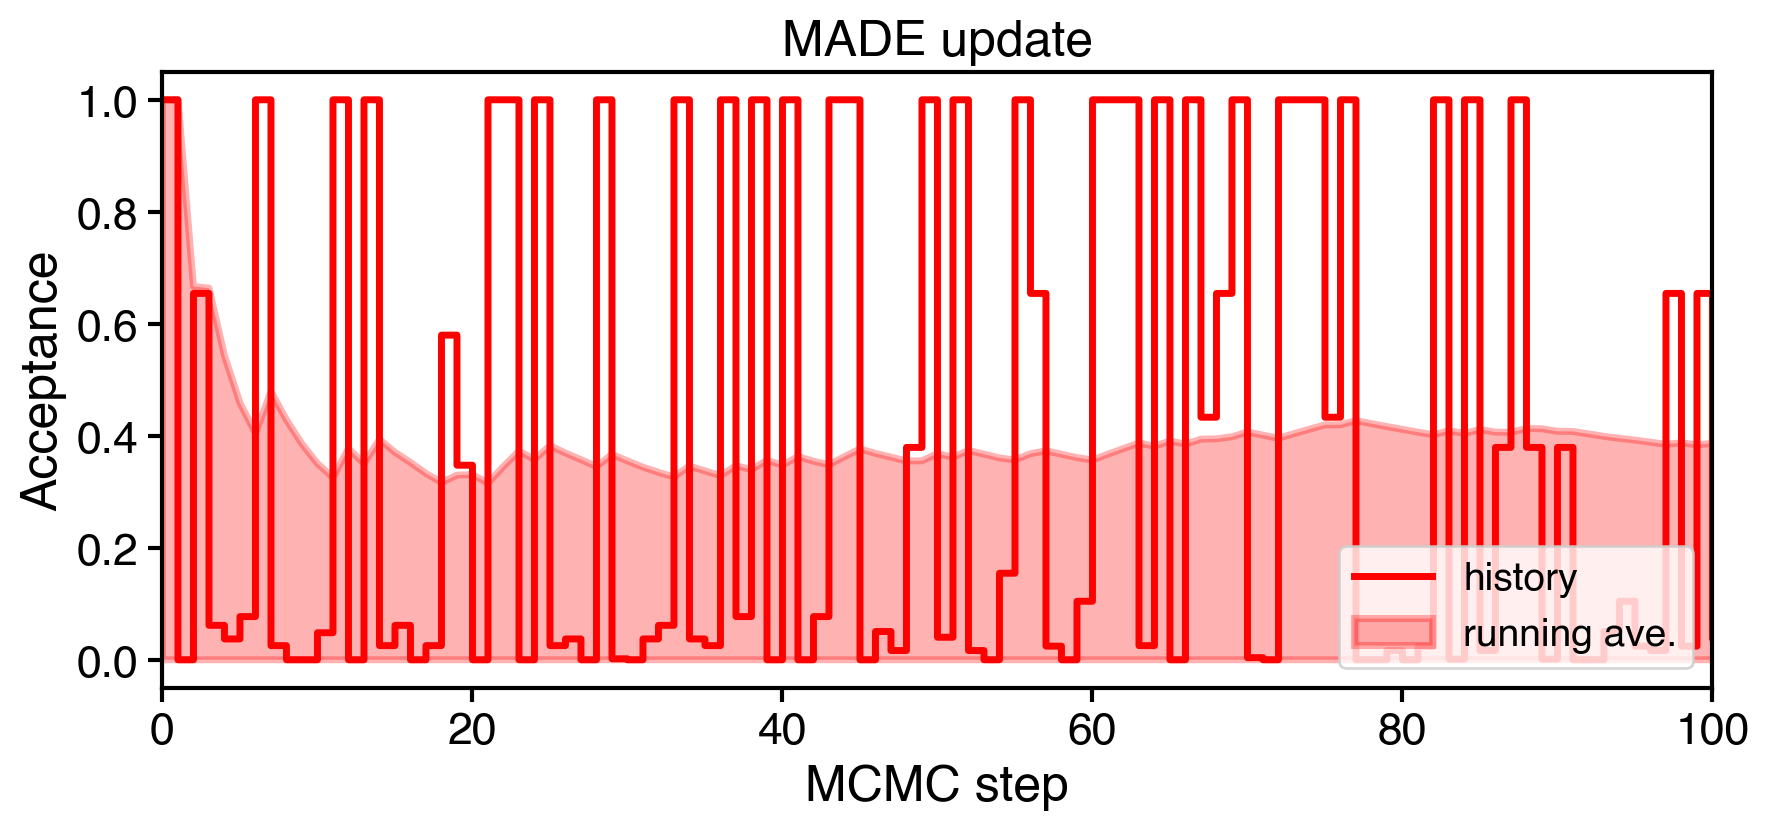

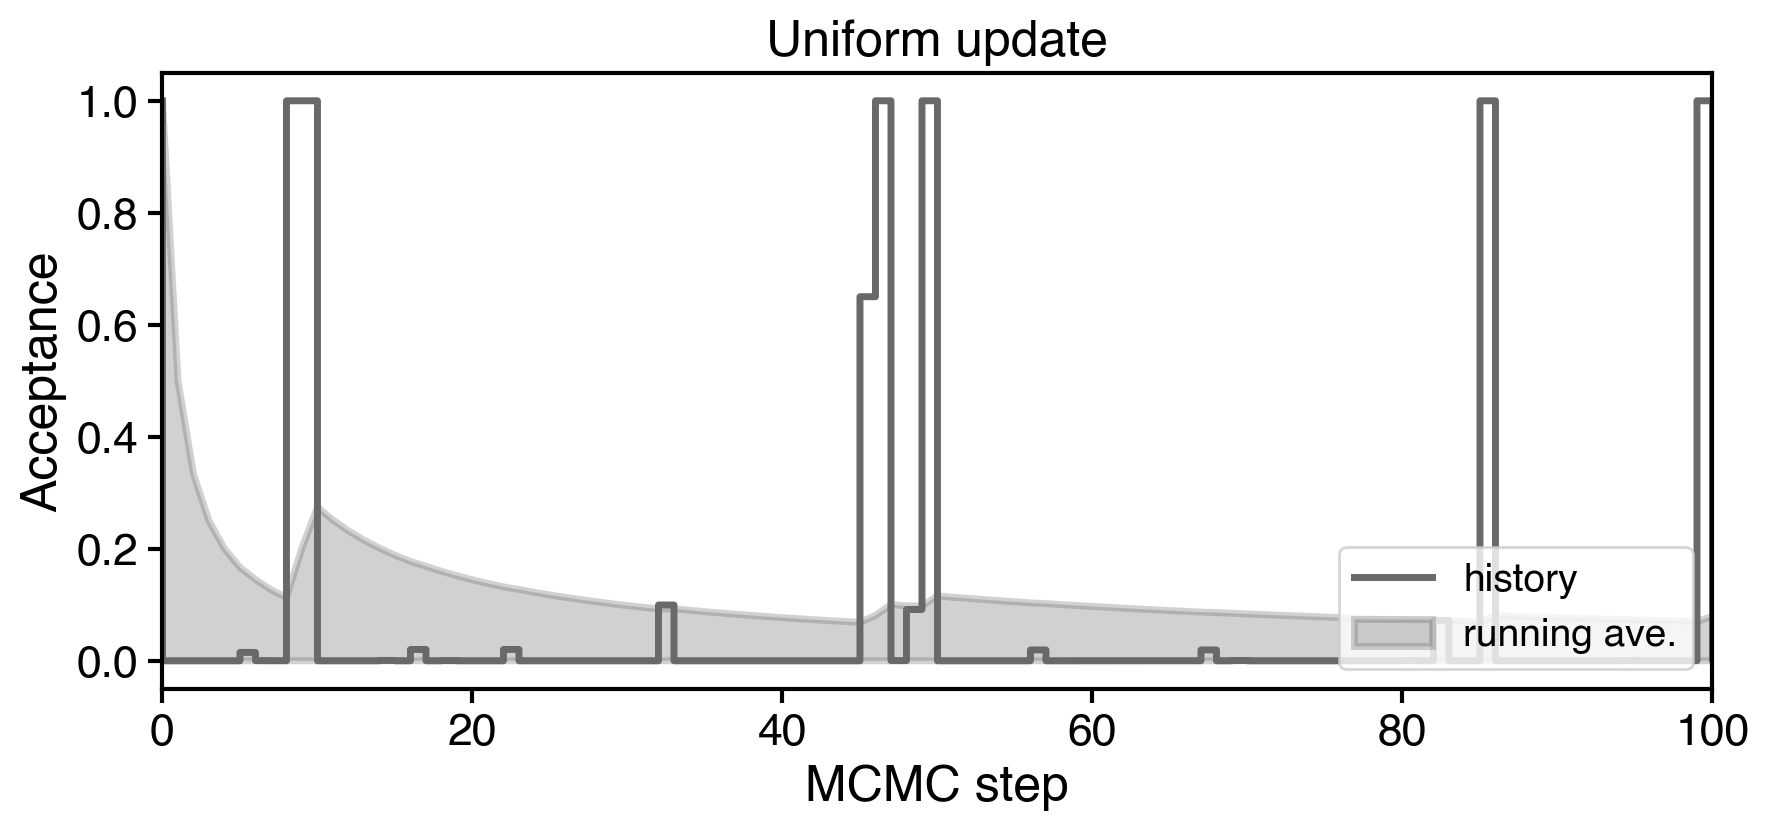

In [195]:
normalize = np.arange(1, acceptance_hist_made.shape[0]+1)
ave_acceptance_made = np.cumsum(acceptance_hist_made) / normalize
ave_acceptance_uni = np.cumsum(acceptance_hist_uni) / normalize

n_range = 100
fig4_1, ax4_1 = plt.subplots(figsize=(10,4), dpi=200)

ax4_1.spines["top"].set_linewidth(spines)
ax4_1.spines["left"].set_linewidth(spines)
ax4_1.spines["bottom"].set_linewidth(spines)
ax4_1.spines["right"].set_linewidth(spines)

ax4_1.step(np.arange(n_iter), acceptance_hist_made, color='red', linewidth=linewidth, label='history')
ax4_1.fill_between(np.arange(n_iter), ave_acceptance_made, color='red', alpha=0.3, linewidth=linewidth, label='running ave.')

ax4_1.set_xlim(0, n_range)
ax4_1.set_ylim(-0.05,1.05)
ax4_1.set_xlabel('MCMC step', fontsize=18)
ax4_1.set_ylabel('Acceptance', fontsize=18)
ax4_1.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax4_1.tick_params(axis="x", which='major', width=1.5)
ax4_1.legend(fontsize=14, loc='lower right', frameon=True)
ax4_1.set_title('MADE update', fontsize=18)

fig4_2, ax4_2 = plt.subplots(figsize=(10,4), dpi=200)

ax4_2.spines["top"].set_linewidth(spines)
ax4_2.spines["left"].set_linewidth(spines)
ax4_2.spines["bottom"].set_linewidth(spines)
ax4_2.spines["right"].set_linewidth(spines)

ax4_2.step(np.arange(n_iter), acceptance_hist_uni, color='dimgrey', linewidth=linewidth, label='history')
ax4_2.fill_between(np.arange(n_iter), ave_acceptance_uni, color='dimgrey', alpha=0.3, linewidth=linewidth, label='running ave.')

ax4_2.set_xlim(0, n_range)
ax4_2.set_ylim(-0.05,1.05)
ax4_2.set_xlabel('MCMC step', fontsize=18)
ax4_2.set_ylabel('Acceptance', fontsize=18)
ax4_2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax4_2.tick_params(axis="x", which='major', width=1.5)
ax4_2.legend(fontsize=14, loc='lower right', frameon=True)
ax4_2.set_title('Uniform update', fontsize=18)

# check the number of NaN counts for acceptance
nan_count_made = np.isnan(acceptance_hist_made).sum()
nan_count_uni = np.isnan(acceptance_hist_uni).sum()
print(f"配列中のNaNの数(MADE): {nan_count_made}/{n_iter}")
print(f"配列中のNaNの数(Uniform): {nan_count_uni}/{n_iter}")